# Active Learning Notebook

Test out using [modAL](https://modal-python.readthedocs.io/en/latest/index.html) with PyMKS.

Todo List:

 - Make work with all the data already evaluated for speedier evaluation
 - Implement with multiple runs and plot uncertainty
 - Implment iGS
 - Make it all functional to some degree
 - PR into PyMKS for an active learning notebook

In [119]:
import numpy as np
import dask.array as da
from dask_ml.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from dask_ml.decomposition import IncrementalPCA
from dask_ml.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

from pymks import (
    generate_multiphase,
    plot_microstructures,
    PrimitiveTransformer,
    TwoPointCorrelation,
    GenericTransformer,
    solve_fe
)

from toolz.curried import curry, pipe, valmap, itemmap, iterate, do
from toolz.curried import map as map_
from modAL.models import ActiveLearner, CommitteeRegressor, BayesianOptimizer
from modAL.disagreement import max_std_sampling
from modAL.models import BayesianOptimizer
from modAL.acquisition import max_EI
import tqdm
import types
from pymks.fmks.func import sequence

## Functions for evaluating learners

Following are functions for evaluating learners. The `oracle_func` generates the `y_data` given some `x_data`. We're assuming that it's expensive to use the oracle. Hence why we need active learning.

In [2]:
@curry
def iterate_times(func, times, value):
    iter_ = iterate(func, value)
    for _ in tqdm.tqdm(range(times)):
        next(iter_)
    return next(iter_)

In [3]:
@curry
def update_learner(oracle_func, x_pool, x_test, y_test, learner):
    query = sequence(
        learner.query,
        oracle_func,
    )
    return pipe(
        learner,
        do(lambda x: x.teach(*query(x_pool))),
        do(lambda x: x.scores.append(x.score(x_test, y_test)))
    )

@curry
def evaluate_learner(oracle_func, x_pool, x_test, y_test, n_query, learner):
    learner.scores = [learner.score(x_test, y_test)]
    return iterate_times(
        update_learner(oracle_func, x_pool, x_test, y_test),
        n_query,
        learner
    )

## Generate Data Functions

Functions to generate the microstructure. The microstructures are stochastically generated from 6 nominal classes.

In [4]:
def shuffle(data):
    tmp = np.array(data)
    np.random.shuffle(tmp)
    return da.from_array(tmp, chunks=data.chunks)

def generate_x(shape, seed):
    da.random.seed(seed)
    np.random.seed(seed)

    tmp = [
        generate_multiphase(shape=shape, grain_size=x, volume_fraction=(0.5, 0.5), chunks=50, percent_variance=0.15)
        for x in [(15, 2), (2, 15), (7, 7), (9, 3), (3, 9), (2, 2)]
    ]
    return np.array(shuffle(da.concatenate(tmp)))

## Functions to generate models

Here we use the GPR model as it returns a probability that's required by the `ActiveLearner` class.

In [26]:
def pca_steps():
    return (
        ("reshape", GenericTransformer(
            lambda x: x.reshape(x.shape[0], x_data.shape[1], x_data.shape[2])
        )),
        ("discritize",PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
        ("correlations",TwoPointCorrelation(periodic_boundary=True, cutoff=31, correlations=[(0, 1), (1, 1)])),
        ('flatten', GenericTransformer(lambda x: x.reshape(x.shape[0], -1))),
        ('pca', IncrementalPCA(n_components=3, svd_solver='full')),
    )

In [6]:
def make_gp_model():
    kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1e2))
    regressor = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
    return Pipeline(steps=pca_steps() + (
        ('poly', PolynomialFeatures(degree=3)),
        ('regressor', regressor),
    ))

def make_linear_model():
    return Pipeline(steps=pca_steps() + (
        ('poly', PolynomialFeatures(degree=3))
        ('regressor', LinearRegression()),
    ))

def pca_model():
    return Pipeline(steps=pca_steps())

## The Oracle

The oracle function is an FE simulation on the 2D grid.

In [66]:
@curry
def oracle_from_data(shape, x_data):
    y_stress = solve_fe(x_data.reshape((-1,) + shape),
                        elastic_modulus=(1.3, 2.5),
                        poissons_ratio=(0.42, 0.35),
                        macro_strain=0.001)['stress'][..., 0]

    return np.array(da.average(y_stress.reshape(y_stress.shape[0], -1), axis=1))

@curry 
def oracle_func(x_data, y_data, query_instance):
    idx, query_value = query_instance
    return query_value.reshape(1, -1), np.array([y_data[idx]]).reshape(1)

## Helper Functions

In [8]:
def plot_parity(y_test, y_predict, label='Testing Data'):
    pred_data = np.array([y_test, y_predict])
    line = np.min(pred_data), np.max(pred_data)
    plt.plot(pred_data[0], pred_data[1], 'o', label=label)
    plt.plot(line, line, '-', linewidth=3, color='k')
    plt.title('Goodness of Fit', fontsize=20)
    plt.xlabel('Actual', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    plt.legend(loc=2, fontsize=15)
    return plt

In [22]:
def three_way_split(x_data, y_data, props, random_state):
    x_0, x_, y_0, y_ = train_test_split(x_data, y_data, train_size=props[0], random_state=random_state)
    x_1, x_2, y_1, y_2 = train_test_split(x_, y_, train_size=props[1] / (1 - props[0]), random_state=random_state)
    return flatten(x_0), flatten(x_1), flatten(x_2), y_0, y_1, y_2

In [10]:
def flatten(x_data):
    return x_data.reshape(x_data.shape[0], -1)

## Greedy Sampling

In [11]:
def split_on_ids(arr, ids):
    mask = np.zeros(len(arr), dtype=bool)
    mask[ids] = True
    return arr[mask], arr[~mask]
    
def calc_distances(d0, d1):
    return np.linalg.norm(d0[:, None, :] - d1[None, :, :], ord=2, axis=-1)

def next_sample(labeled_samples, scores):
    scores_labeled, scores_unlabeled = split_on_ids(scores, labeled_samples)
    _, unlabeled_ids = split_on_ids(np.arange(len(scores)), labeled_samples)
    if len(scores_labeled) == 0:
        scores_labeled = np.mean(scores_unlabeled, axis=0)[None]
    distances_nk = calc_distances(scores_unlabeled, scores_labeled)
    distances_n = np.min(distances_nk, axis=1)
    return unlabeled_ids[np.argmax(distances_n)]
                                         
def gsx_query(model, x_pool):
    if not hasattr(model, 'gsx_data'):
        model.gsx_data = [], pca_model().fit_transform(x_pool)
    labeled_samples, scores = model.gsx_data
    next_id = next_sample(labeled_samples, scores)
    model.gsx_data = (labeled_samples + [next_id], scores)
    return next_id, x_pool[next_id]

def gsy_query(model, x_pool):
    if not hasattr(model, 'labeled_samples'):
        model.labeled_samples = []
    y_pool = model.predict(x_pool)
    next_id = next_sample(model.labeled_samples, y_pool.reshape(-1, 1))
    model.labeled_samples = model.labeled_samples + [next_id]
    return next_id, x_pool[next_id]

# Active Learning!

## Generate Data

In [63]:
print(x_test.shape)
print(x_train.shape)
print(x_pool.shape)
print(x_data.shape)
print(y_train.shape)

(96, 1681)
(24, 1681)
(480, 1681)
(600, 41, 41)
(24,)


## Set up the active learners

One is a GPR using the maximum std and the other is random

In [188]:
query_std = lambda model, x_: pipe(
    model.predict(x_, return_std=True)[1],
    np.argmax,
    lambda i: (i, x_[i])
)

query_random = lambda model, x_: pipe(
    np.random.randint(0, len(x_)),
    lambda i: (i, x_[i])
)

def make_ensemble(x_train, y_train):
    ensemble_learner = CommitteeRegressor(
        learner_list=[
            ActiveLearner(
                estimator=make_gp_model(),
                X_training=x_train_,
                y_training=y_train_
            )
            for x_train_, y_train_ in zip(np.array_split(x_train, 5), np.array_split(y_train, 5))
        ],
        query_strategy=max_std_sampling
    )

    ## required because CommitteeRegressor does not have a score function

    def score(self, x_true, y_true):
        y_pred = self.predict(x_true)
        return r2_score(y_true, y_pred)

    ensemble_learner.score = types.MethodType(score, ensemble_learner)
    
    return ensemble_learner

@curry
def make_learner(x_train, y_train, klass, query_func):
    return klass(
        estimator=make_gp_model(),
        query_strategy=query_func,
        X_training=x_train,
        y_training=y_train,
    )

def make_bayes(x_train, y_train):
    return make_learner(x_train, y_train, BayesianOptimizer, max_EI)

def make_learners(x_train, y_train):
    make_active = make_learner(x_train, y_train, ActiveLearner)

    return dict(
        std=make_active(query_std),
        random=make_active(query_random),
#        ensemble=make_ensemble(x_train, y_train),
        bayes=make_bayes(x_train, y_train),
        gsx=make_active(gsx_query),
        gsy=make_active(gsy_query)
    )

In [189]:
@curry
def evaluate_item(oracle, x_pool, x_test, y_test, iterations, item):
    name, learner = item
    print('evaluating', name)
    return name, evaluate_learner(oracle, x_pool, x_test, y_test, iterations, learner)

@curry
def one_round(x_data, y_data, iterations, seed):
    x_pool, x_test, x_train, y_pool, y_test, y_train = three_way_split(x_data, y_data, (0.8, 0.16), seed)
    oracle = oracle_func(x_pool, y_pool)
    eval_item = evaluate_item(oracle, x_pool, x_test, y_test, iterations)
    return itemmap(eval_item, make_learners(x_train, y_train))

def multiple_rounds(x_data, y_data, rounds, iterations):
    process_scores = sequence(
        lambda _: one_round(x_data, y_data, iterations, None),
        valmap(lambda x: x.scores)
    )
    
    return pipe(
        [None] * rounds,
        map_(process_scores),
        list,
        lambda x: merge_with(np.vstack)(*x),
        valmap(lambda x: (np.mean(x, axis=0), np.std(x, axis=0)))
    )

## Generate the data

In [12]:
grid_shape = (41, 41)
n_sample_per_class = 100
x_data = generate_x((n_sample_per_class,) + grid_shape, 5)
y_data = oracle_from_data(grid_shape, x_data)

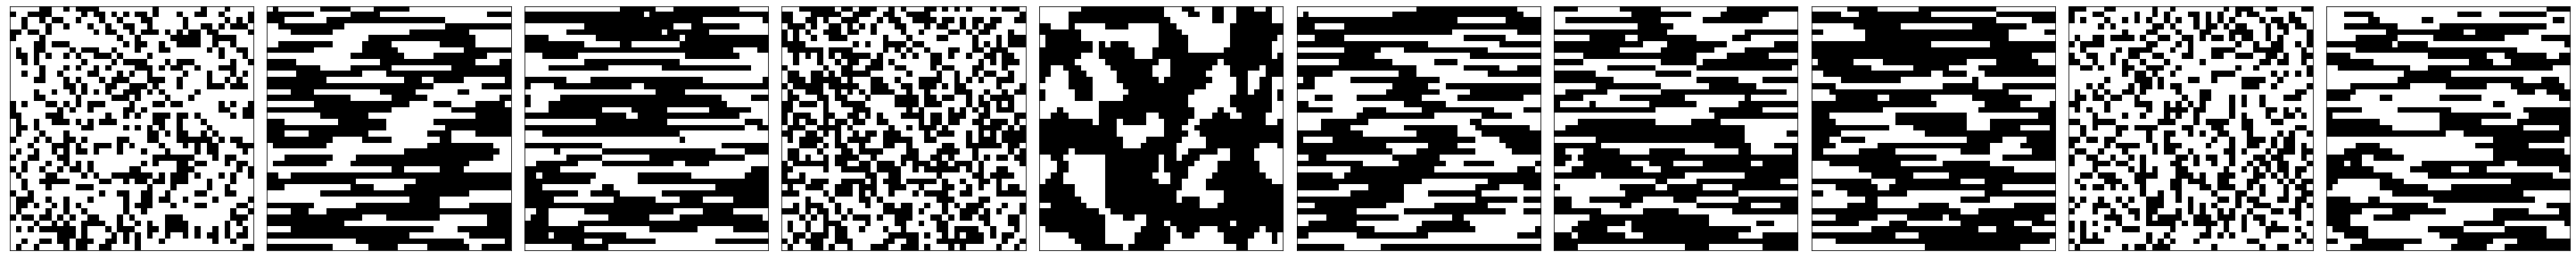

In [62]:
plot_microstructures(*x_data[:10], cmap='gray', colorbar=False);

## Run the learners

In [190]:
scores = multiple_rounds(x_data, y_data, 10, 100)

evaluating std


100%|██████████| 100/100 [02:04<00:00,  1.25s/it]


evaluating random


100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


evaluating bayes


100%|██████████| 100/100 [02:21<00:00,  1.42s/it]


evaluating gsx


100%|██████████| 100/100 [02:20<00:00,  1.41s/it]


evaluating gsy


100%|██████████| 100/100 [02:19<00:00,  1.39s/it]


evaluating std


100%|██████████| 100/100 [02:20<00:00,  1.40s/it]


evaluating random


100%|██████████| 100/100 [02:04<00:00,  1.24s/it]


evaluating bayes


100%|██████████| 100/100 [02:26<00:00,  1.46s/it]


evaluating gsx


100%|██████████| 100/100 [02:06<00:00,  1.27s/it]


evaluating gsy


100%|██████████| 100/100 [02:04<00:00,  1.24s/it]


evaluating std


100%|██████████| 100/100 [02:04<00:00,  1.25s/it]


evaluating random


100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


evaluating bayes


100%|██████████| 100/100 [02:05<00:00,  1.25s/it]


evaluating gsx


100%|██████████| 100/100 [02:04<00:00,  1.25s/it]


evaluating gsy


100%|██████████| 100/100 [02:03<00:00,  1.24s/it]


evaluating std


100%|██████████| 100/100 [02:04<00:00,  1.25s/it]


evaluating random


100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


evaluating bayes


100%|██████████| 100/100 [02:04<00:00,  1.25s/it]


evaluating gsx


100%|██████████| 100/100 [02:04<00:00,  1.25s/it]


evaluating gsy


100%|██████████| 100/100 [02:03<00:00,  1.24s/it]


evaluating std


100%|██████████| 100/100 [02:04<00:00,  1.24s/it]


evaluating random


100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


evaluating bayes


100%|██████████| 100/100 [02:04<00:00,  1.25s/it]


evaluating gsx


100%|██████████| 100/100 [02:04<00:00,  1.25s/it]


evaluating gsy


100%|██████████| 100/100 [02:03<00:00,  1.23s/it]


evaluating std


100%|██████████| 100/100 [02:03<00:00,  1.24s/it]


evaluating random


100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


evaluating bayes


100%|██████████| 100/100 [02:04<00:00,  1.24s/it]


evaluating gsx


100%|██████████| 100/100 [02:03<00:00,  1.24s/it]


evaluating gsy


100%|██████████| 100/100 [02:02<00:00,  1.23s/it]


evaluating std


100%|██████████| 100/100 [02:03<00:00,  1.23s/it]


evaluating random


100%|██████████| 100/100 [01:43<00:00,  1.04s/it]


evaluating bayes


100%|██████████| 100/100 [02:03<00:00,  1.23s/it]


evaluating gsx


100%|██████████| 100/100 [02:02<00:00,  1.23s/it]


evaluating gsy


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


evaluating std


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


evaluating random


100%|██████████| 100/100 [01:42<00:00,  1.02s/it]


evaluating bayes


100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


evaluating gsx


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


evaluating gsy


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


evaluating std


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


evaluating random


100%|██████████| 100/100 [01:39<00:00,  1.01it/s]


evaluating bayes


100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


evaluating gsx


100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


evaluating gsy


100%|██████████| 100/100 [01:56<00:00,  1.16s/it]


evaluating std


100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


evaluating random


100%|██████████| 100/100 [01:38<00:00,  1.01it/s]


evaluating bayes


100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


evaluating gsx


100%|██████████| 100/100 [01:56<00:00,  1.16s/it]


evaluating gsy


100%|██████████| 100/100 [01:56<00:00,  1.16s/it]



## The results

(0.9, 1.0)

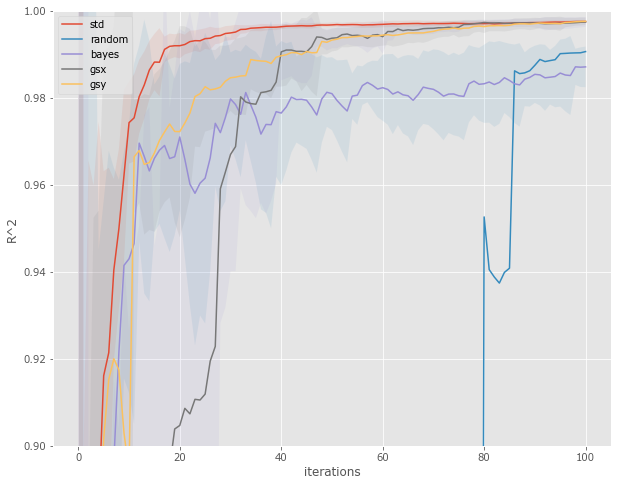

In [196]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 8))
ax = plt.gca()

for k, v in scores.items():
    y = v[0]
    e = v[1]
    x = np.arange(len(y))
    ax.plot(x, y, label=k)
    if k in ['std', 'bayes', 'gsx', 'gsy']:
        ax.fill_between(x, y - e, y + e, alpha=0.1)
plt.legend()
plt.xlabel('iterations')
plt.ylabel('R^2');
plt.ylim(0.9, 1)

## Check what the accuracy actually looks like

In [79]:
y_pred_std = learner_accuracy['std'][1].predict(x_test)
y_pred_random = learner_accuracy['random'][1].predict(x_test)

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

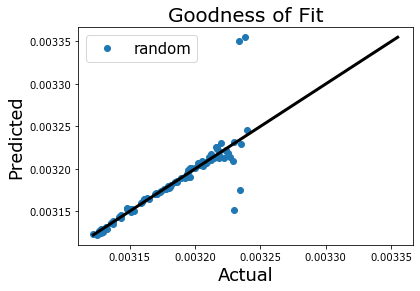

In [89]:
plot_parity(y_test, y_pred_random, label='random')

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

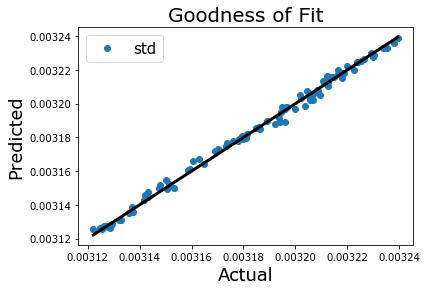

In [90]:
plot_parity(y_test, y_pred_std, label='std')

## Sandbox

In [36]:
out = evaluate_learner(oracle, x_pool, evaluate_func(x_test, y_test), 30, gsx_learner)

100%|██████████| 30/30 [00:57<00:00,  1.93s/it]


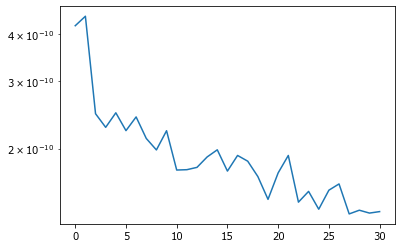

In [37]:
plt.semilogy(out[0])